In [1]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Energy consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 09/04/25

### **Library**

In [2]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import warnings
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet
import itertools

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math
from typing import List, Callable, Union, Dict, Any, Tuple

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

# Machine Learning Libraries
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
							  ExtraTreesClassifier, ExtraTreesRegressor,
							  BaggingClassifier, BaggingRegressor,
							  GradientBoostingClassifier, GradientBoostingRegressor,
							  AdaBoostClassifier, AdaBoostRegressor,
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow as tf
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer,
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score,
							 roc_curve, auc, roc_auc_score, RocCurveDisplay,
							 confusion_matrix, ConfusionMatrixDisplay,
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

import itertools

/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anac

### **EDA**

In [3]:
# Load data
df = pd.read_csv('data/cleaned/energy_consumption.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 25 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Year                                             756 non-null    int64  
 1   Month                                            756 non-null    int64  
 2   Region                                           756 non-null    object 
 3   Number of Households                             756 non-null    float64
 4   Avg Electricity Consumption per Household (kWh)  756 non-null    float64
 5   Number of Tropical Nights                        756 non-null    float64
 6   Number of Heat Wave Days                         756 non-null    float64
 7   Number of Cold Wave Days                         756 non-null    float64
 8   Avg Temperature (Celsius)                        756 non-null    float64
 9   Avg Max Temperature (Celsius)   

In [4]:
def dual_features_plot(a: str, b: str, c: str):
	'''
	Generate a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.
	'''

	if c == 'Month': # Take mean for Month
		data = df.groupby(c)[[a, b]].mean().reset_index()
	elif c == 'Year': # Take cumulative sum for Year
		data = df.groupby(c)[[a, b]].sum().reset_index()
	else:
		raise ValueError("Grouping column must be 'Month' or 'Year'")

	# Axis 1
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(data[c], data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')

	# Axis 2
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(data[c], data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	for x_val,y_val in zip(data[c],data[b]):
		ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=9,color='black')

	plt.title(f'{a} & {b} from 2016 to 2024')
	plt.grid()
	plt.tight_layout()
	plt.show()

In [5]:
def triple_features_plot(df, a: str, b: str, c: str, d: str):
	'''
	Generate a triple-axis plot to visualize a, b, c based on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare. (Bar)
	b (str): Column name for data in the DataFrame to compare. (Line)
	c (str): Column name for data in the DataFrame to compare. (Line)
	d (str): Column name for data in the DataFrame to set base on.
	'''

	if d == 'Month':
		data = df.groupby(d)[[a, b, c]].mean().reset_index()
	elif d == 'Year':
		data = df.groupby(d)[[a, b, c]].sum().reset_index()
	else:
		raise ValueError("Grouping column must be 'Month' or 'Year'")

	fig, ax1 = plt.subplots(figsize=(10, 6))

	# Axis 1
	ax1.set_xlabel(d)
	ax1.set_ylabel(a, color='orange')
	bars = ax1.bar(data[d], data[a], color='orange', label=a)
	ax1.tick_params(axis='y', labelcolor='orange')

	# Axis 2
	ax2 = ax1.twinx()
	ax2.set_ylabel(b, color='blue')
	p2, = ax2.plot(data[d], data[b], color='blue', marker='o', label=b)
	ax2.tick_params(axis='y', labelcolor='blue')

	# Axis 3
	ax3 = ax1.twinx()
	ax3.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap
	ax3.set_ylabel(c, color='green')
	p3, = ax3.plot(data[d], data[c], color='green', marker='s', label=c)
	ax3.tick_params(axis='y', labelcolor='green')

	fig.suptitle(f'{a}, {b}, and {c} grouped by {d}')
	plt.grid()
	fig.tight_layout()
	fig.legend([bars, p2, p3], [a, b, c], loc='upper left', bbox_to_anchor=(0.07, 0.91))
	plt.show()

In [6]:
def one_feature_two_group (a: str, b: str, c: str):
	"""
	Plot the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.

	Parameters:
	a (str): Name of the main category column in df (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df (e.g., a more granular group like 'City').
	c (str): Name of the feature / metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean = df.groupby([f'{a}',f'{b}'])[c].mean()
	unstacked_df = df_mean.unstack(level=f'{a}')
	plt.figure(figsize=(12, 8))
	unstacked_df.plot(kind='line',marker='o',ax=plt.gca())


	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')
	plt.show()

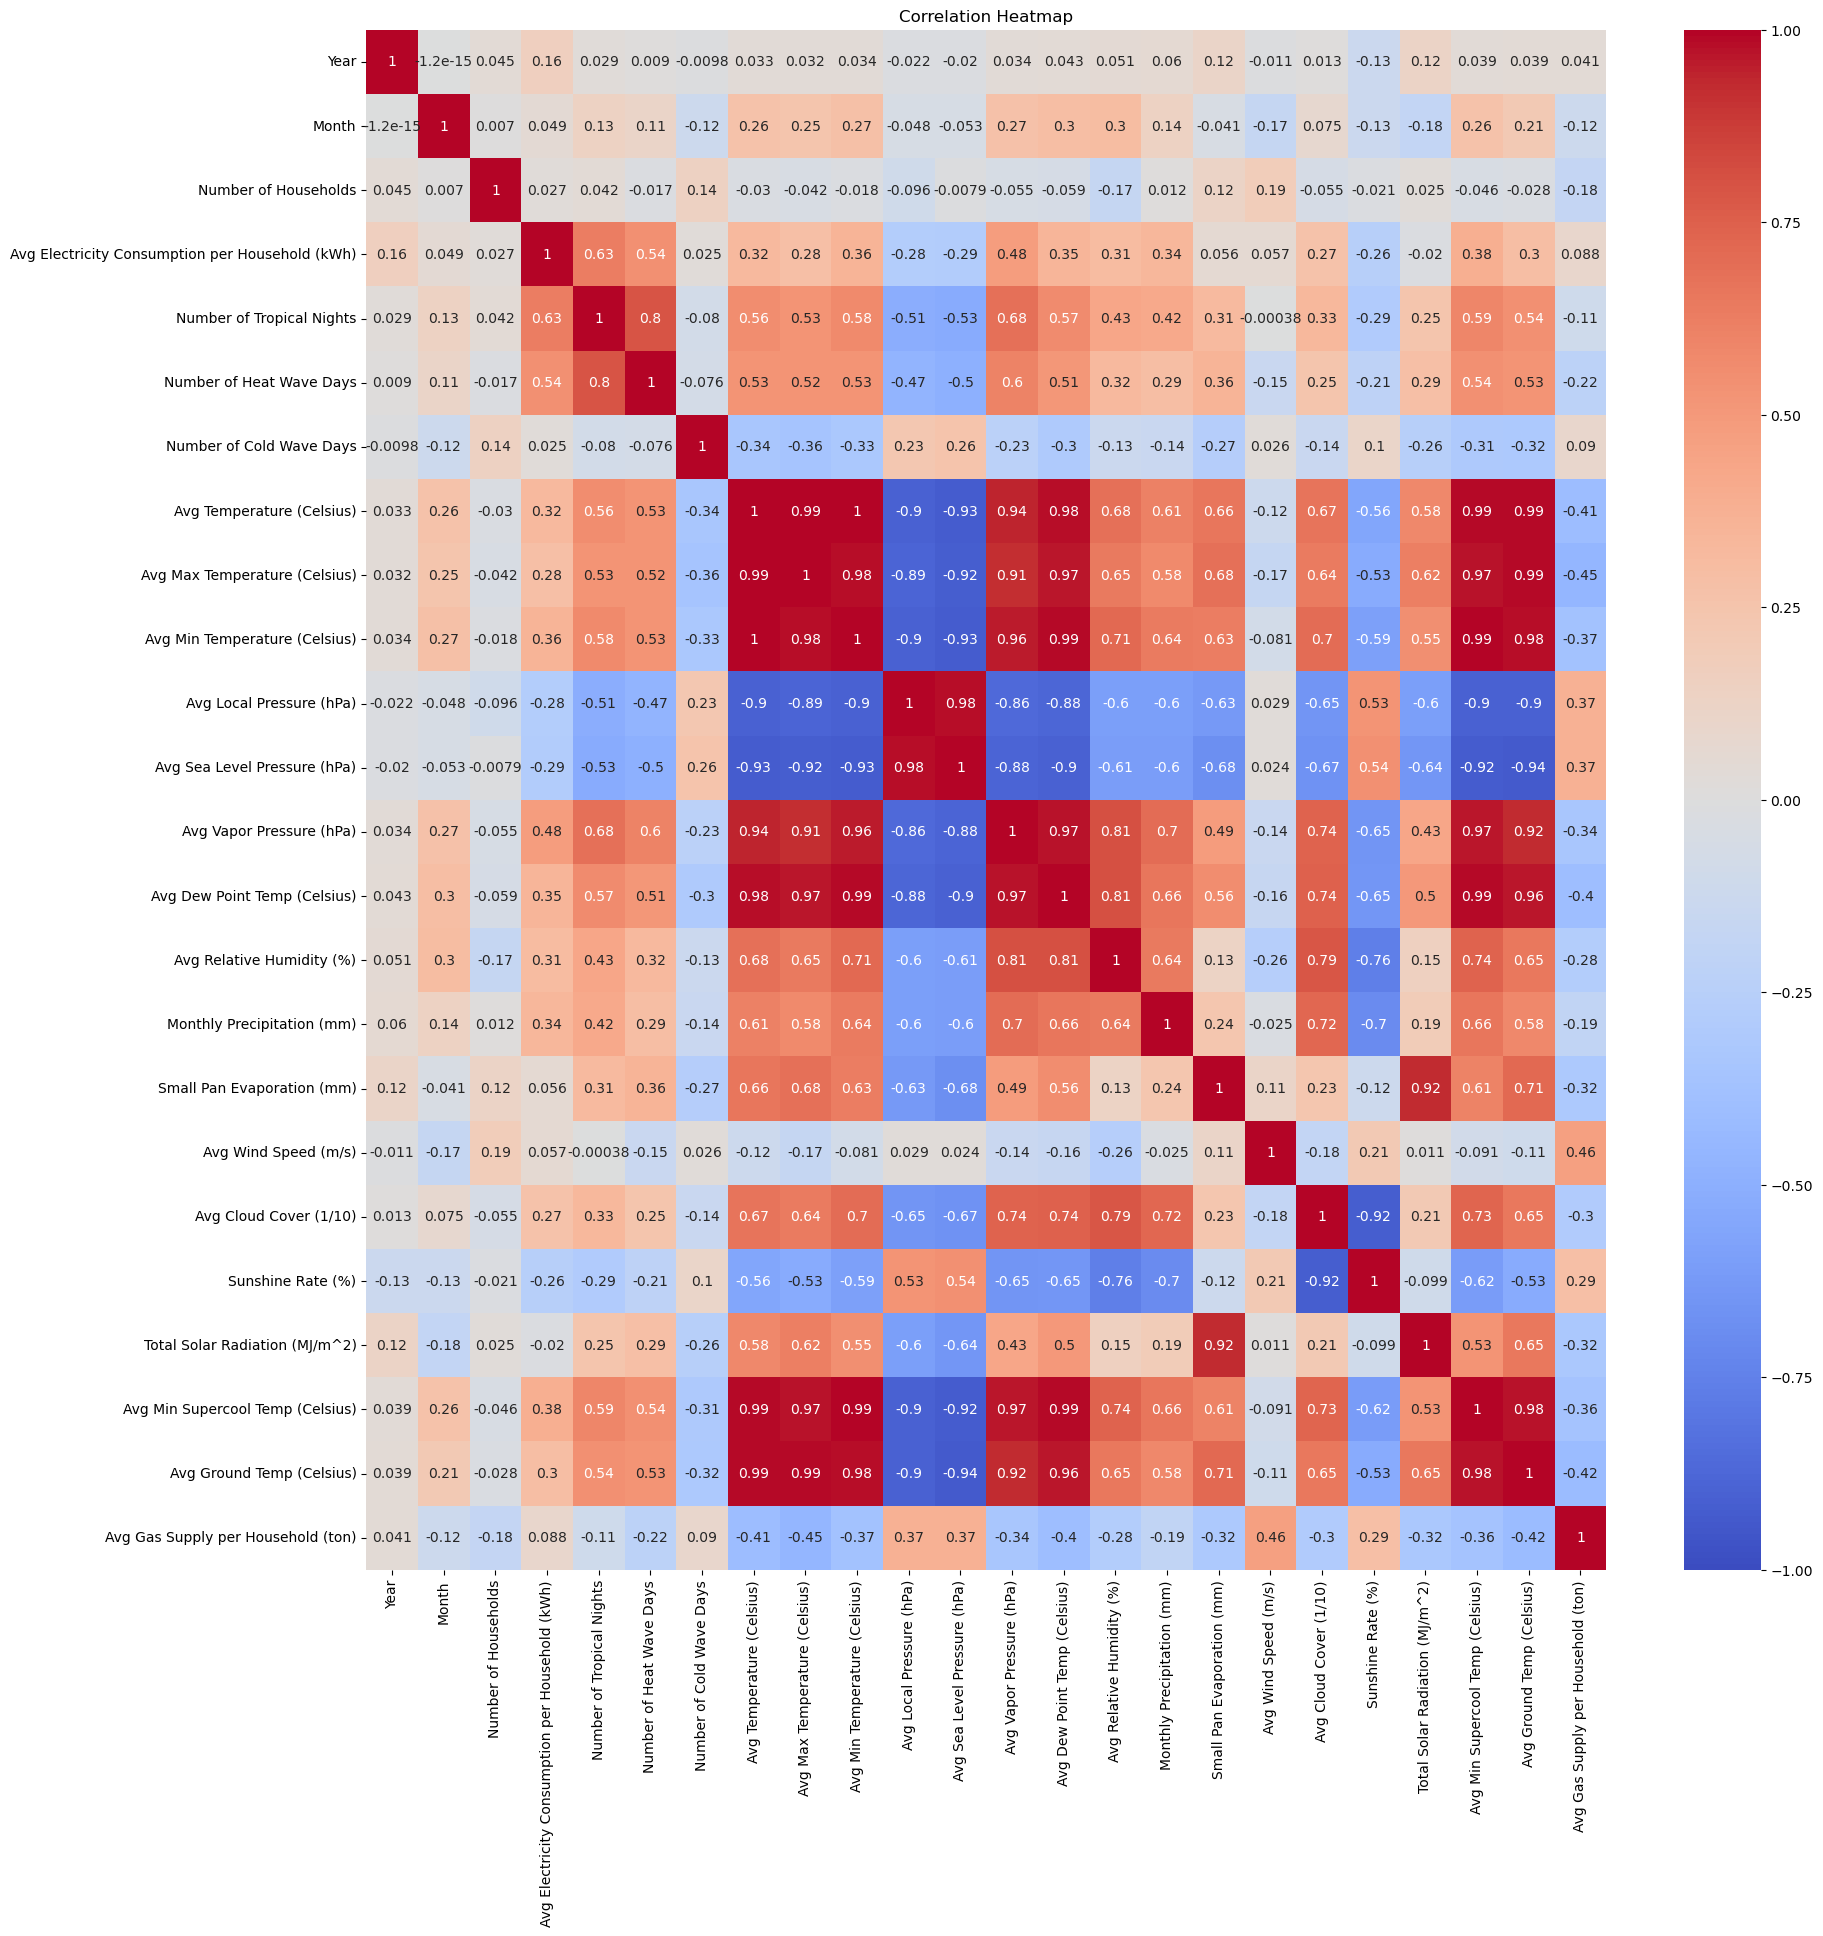

In [7]:
# Heatmap
df_numeric=df.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Electricity Consumption per Household (kWh)'])<0.2].index
# filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

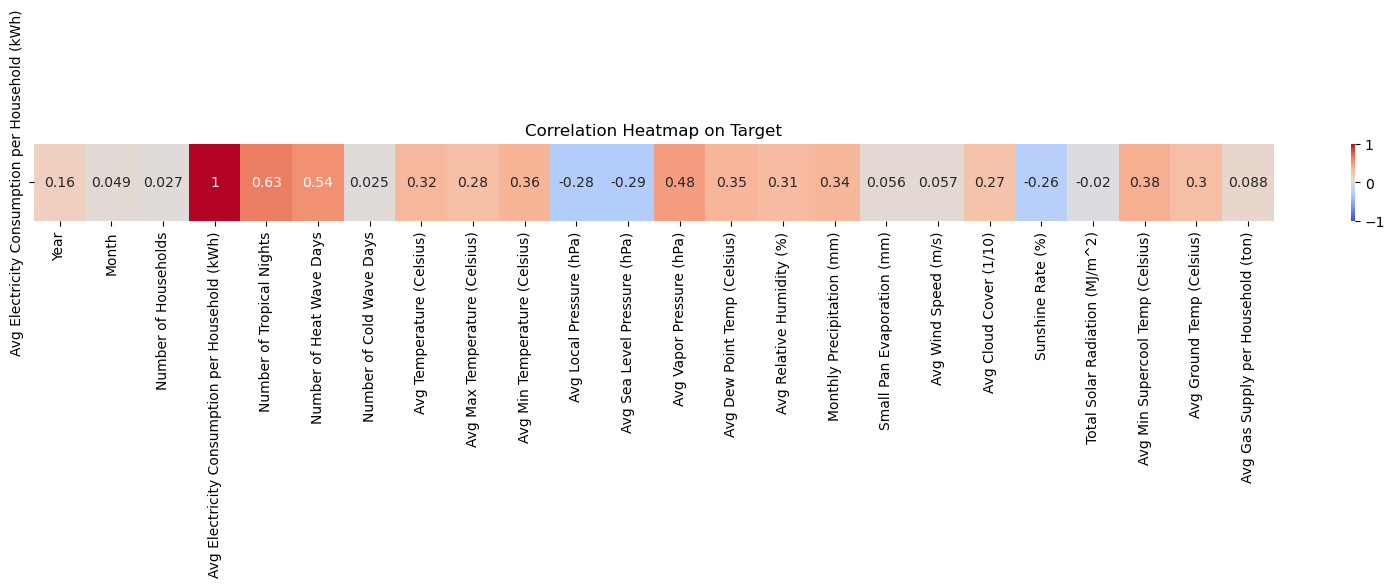

In [8]:
# Heatmap on Avg Electricity Consumption per Household (kWh)
df_numeric = df.select_dtypes(include=['number'])
df_corr = df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Electricity Consumption per Household (kWh)'])<0.2].index
df_corr = df_corr.loc[['Avg Electricity Consumption per Household (kWh)']]
#filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20, 1))
sns.heatmap(df_corr, annot=True, vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

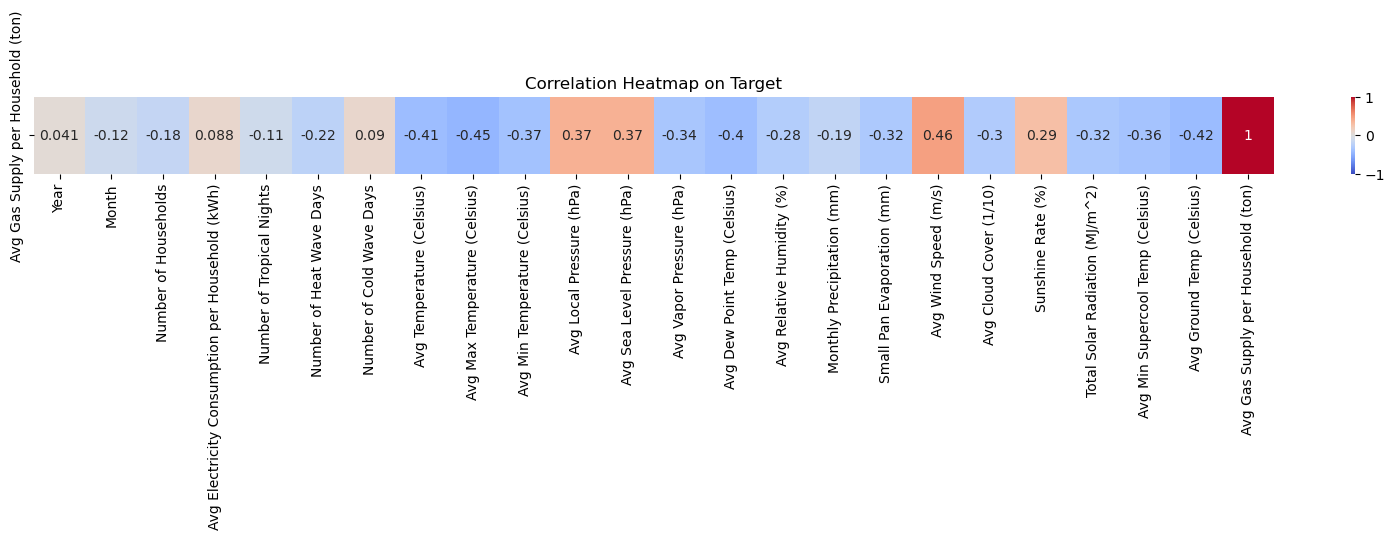

In [9]:
# Heatmap on Avg Gas Supply per Household (ton)
df_numeric = df.select_dtypes(include=['number'])
df_corr = df_numeric.corr()
df_corr = df_corr.loc[['Avg Gas Supply per Household (ton)']]
plt.figure(figsize=(20, 1))
sns.heatmap(df_corr, annot=True, vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

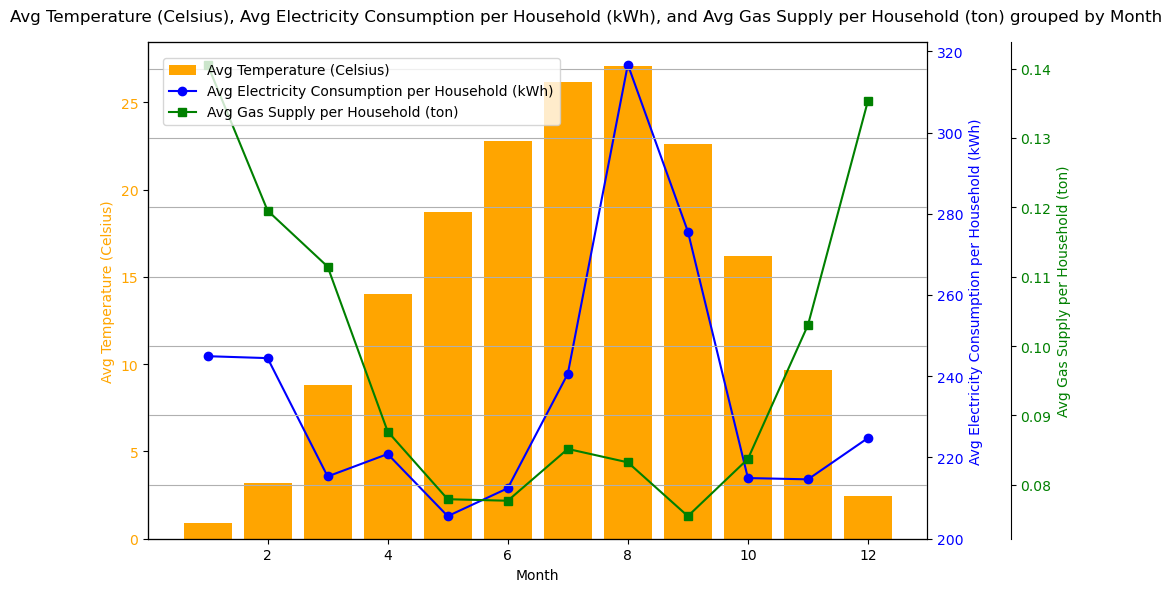

In [10]:
# Monthly average temperature, electricity consumption and gas supply
triple_features_plot(df, 'Avg Temperature (Celsius)', 'Avg Electricity Consumption per Household (kWh)', 'Avg Gas Supply per Household (ton)', 'Month')

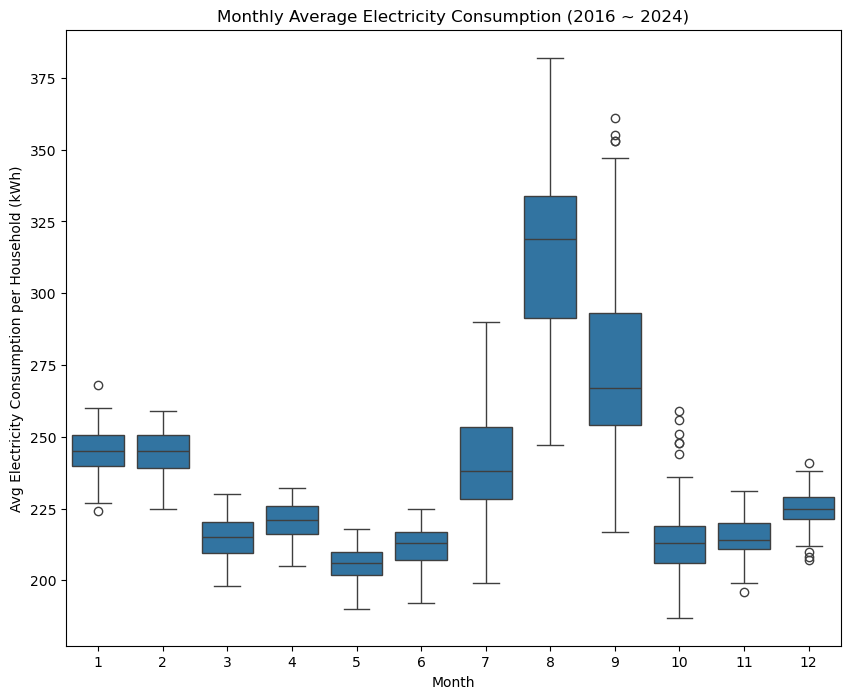

In [11]:
# Monthly average electricity consumption box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Avg Electricity Consumption per Household (kWh)')
plt.title("Monthly Average Electricity Consumption (2016 ~ 2024)")
plt.xlabel("Month")
plt.ylabel("Avg Electricity Consumption per Household (kWh)")
plt.show()

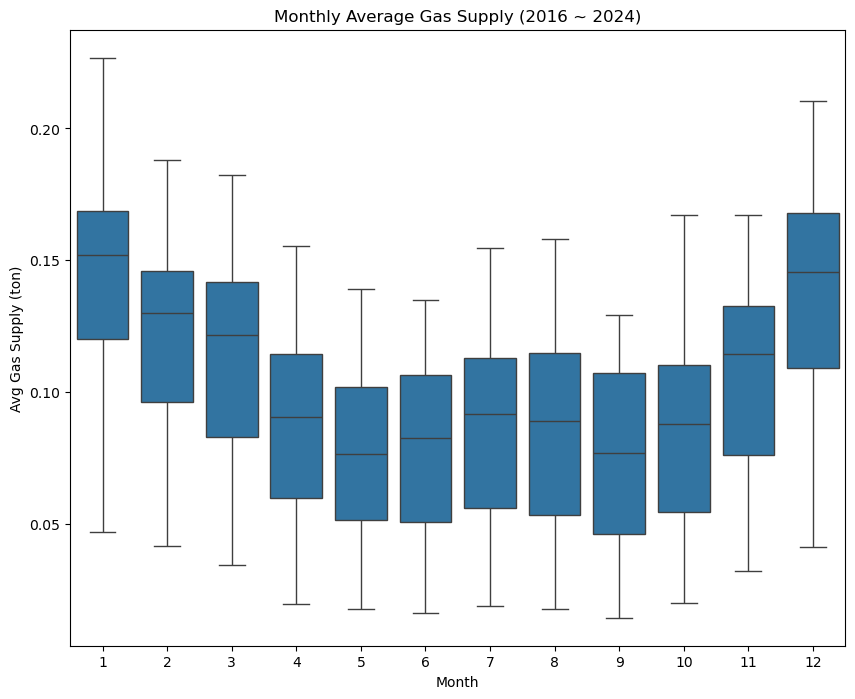

In [12]:
# Monthly average gas supply box plot
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='Month', y='Avg Gas Supply per Household (ton)')
plt.title("Monthly Average Gas Supply (2016 ~ 2024)")
plt.xlabel("Month")
plt.ylabel("Avg Gas Supply (ton)")
plt.show()

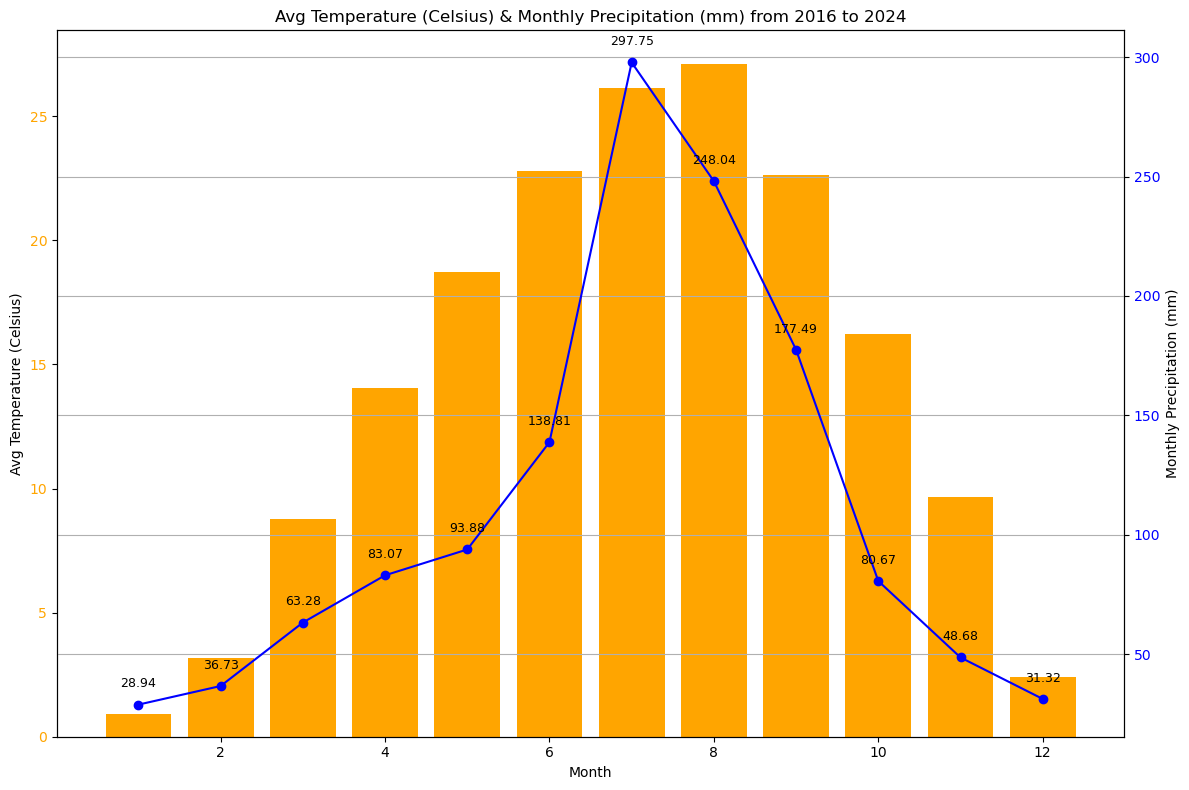

In [13]:
# Monthly temperature and precipitation plot
dual_features_plot(a='Avg Temperature (Celsius)', b='Monthly Precipitation (mm)', c='Month')


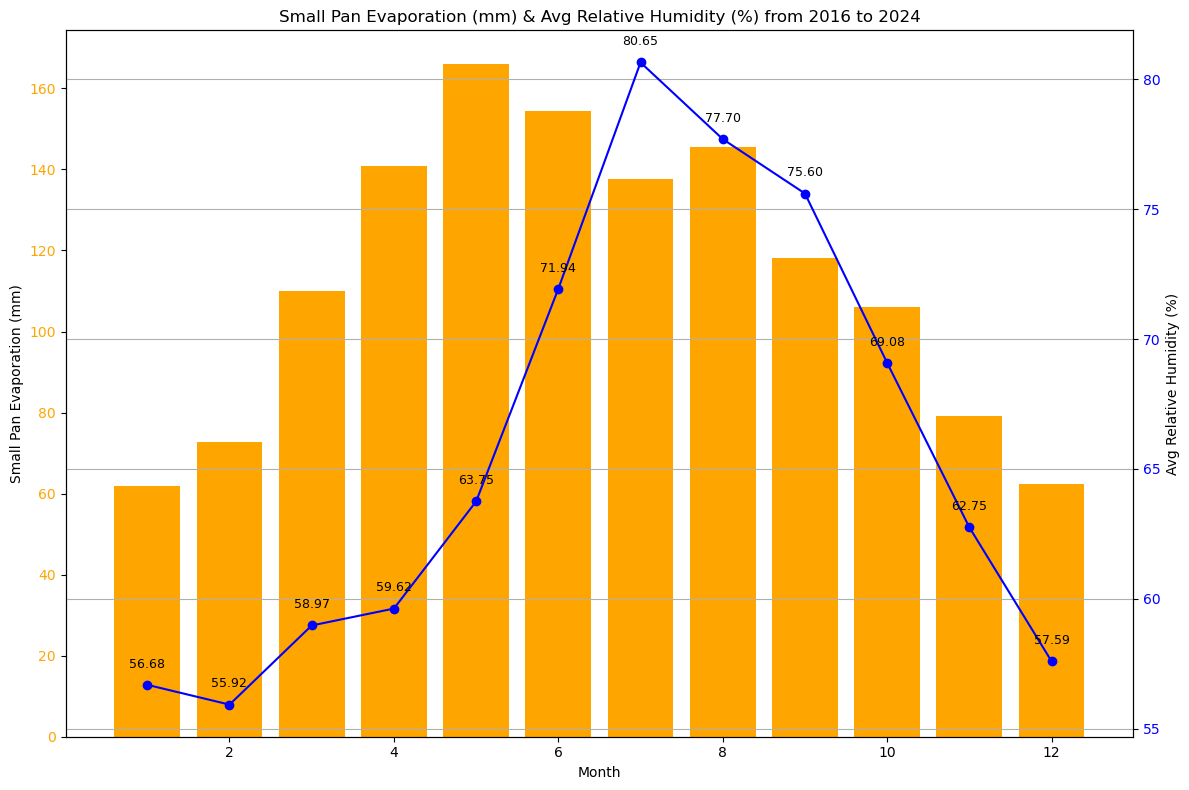

In [14]:
# Monthly small pan evapouration and avg relative humidity
dual_features_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

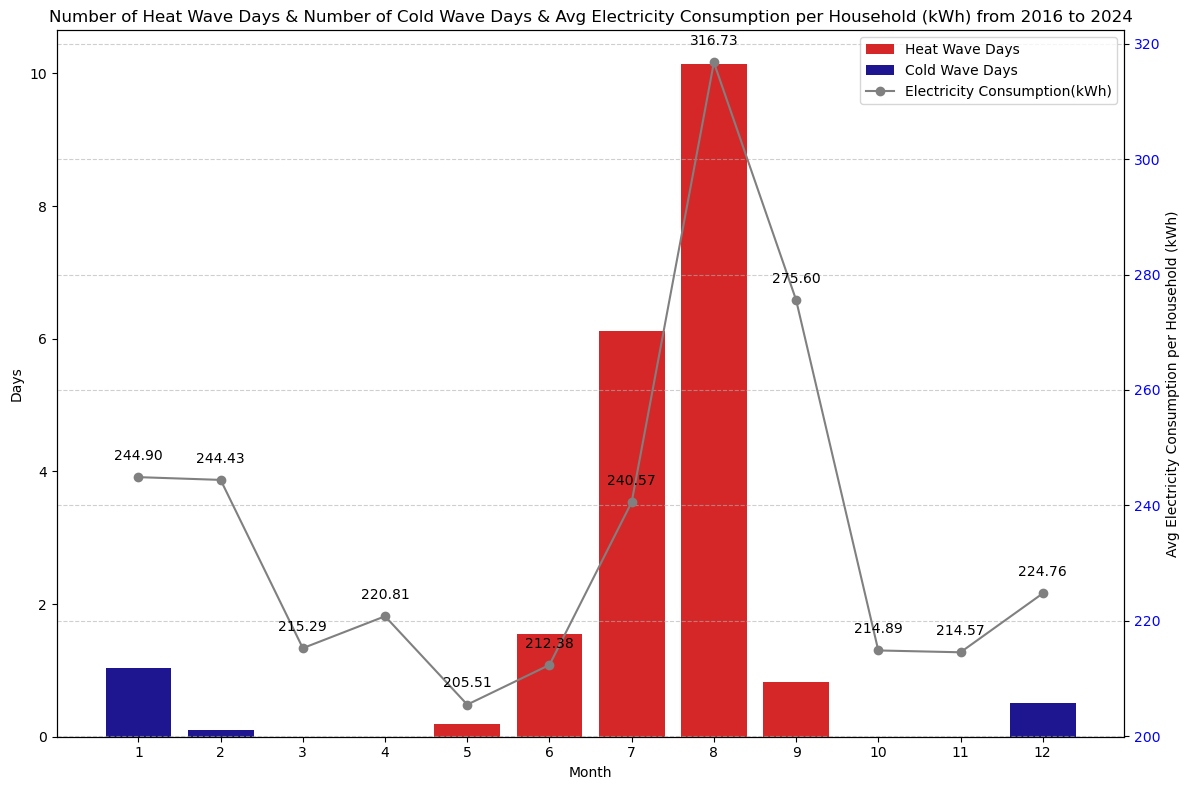

In [15]:
# Monthly heat wave days & cold wave days & energy consumption
bar_widths = 0.5
color_a = 'tab:red'
color_b = '#1e1690'
color_c = 'tab:orange'
col_a = 'Heat Wave Days'
col_b = 'Cold Wave Days'
col_c = 'Tropical Nights'
data = df.groupby('Month')[['Number of Heat Wave Days', 'Number of Cold Wave Days','Number of Tropical Nights']].mean().reset_index()
data_mean = df.groupby('Month')[['Avg Electricity Consumption per Household (kWh)']].mean().reset_index()
fig, ax_1 = plt.subplots(figsize=(12, 8))
months = data['Month'].unique()
x = np.arange(len(months))
rects1 = ax_1.bar(data['Month'], data['Number of Heat Wave Days'],label=col_a , color=color_a)
rects2 = ax_1.bar(data['Month'],  data['Number of Cold Wave Days'],label=col_b, color=color_b)
ax_1.set_xticks(data['Month'])
ax_1.set_xlabel('Month')
ax_1.set_ylabel('Days')
ax_1.tick_params(axis='y', labelcolor='black')

#######
col_d = 'Electricity Consumption(kWh)'
ax_2 = ax_1.twinx()
ax_2.set_ylabel('Avg Electricity Consumption per Household (kWh)')
plot_c=ax_2.plot(data_mean['Month'], data_mean['Avg Electricity Consumption per Household (kWh)'], marker='o', color='grey',label=col_d )
ax_2.tick_params(axis='y', labelcolor='blue')
for x_val,y_val in zip(data_mean['Month'],data_mean['Avg Electricity Consumption per Household (kWh)']):
	ax_2.text(x_val, y_val +(ax_2.get_ylim()[1] - ax_2.get_ylim()[0]) * 0.02,f'{y_val:.2f}',ha='center',va='bottom',fontsize=10,color='black')
plt.title(f'Number of Heat Wave Days & Number of Cold Wave Days & Avg Electricity Consumption per Household (kWh) from 2016 to 2024')
plt.grid(True, linestyle='--', alpha=0.6, zorder=0)
plt.tight_layout()
handles_to_combine = [rects1, rects2] + plot_c
labels_to_combine = [h.get_label() for h in handles_to_combine]
h1,l1 =ax_1.get_legend_handles_labels()
h2,l2 =ax_2.get_legend_handles_labels()
handles = h1 + h2
labels = l1 + l2
plt.legend(handles,labels,loc='best')
plt.show()

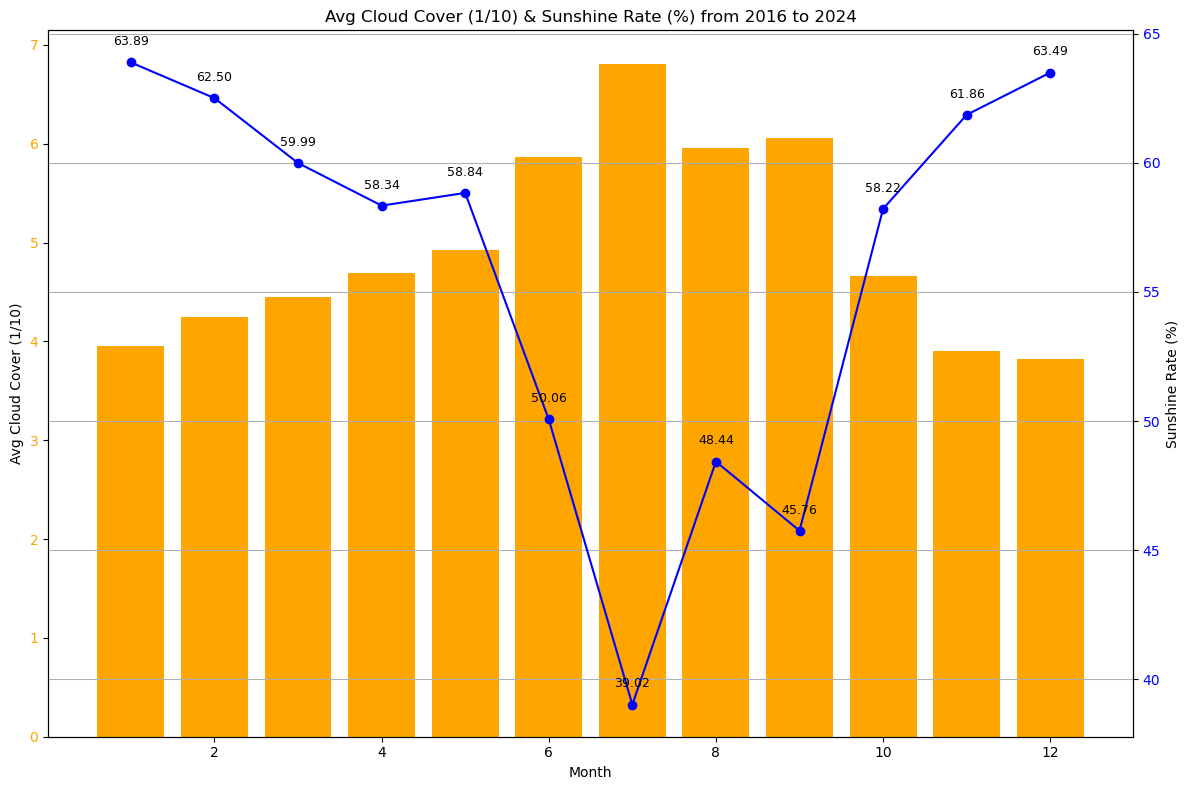

In [16]:
# Monthly avg cloud cover and sunshine rate
dual_features_plot(a='Avg Cloud Cover (1/10)', b='Sunshine Rate (%)', c='Month')

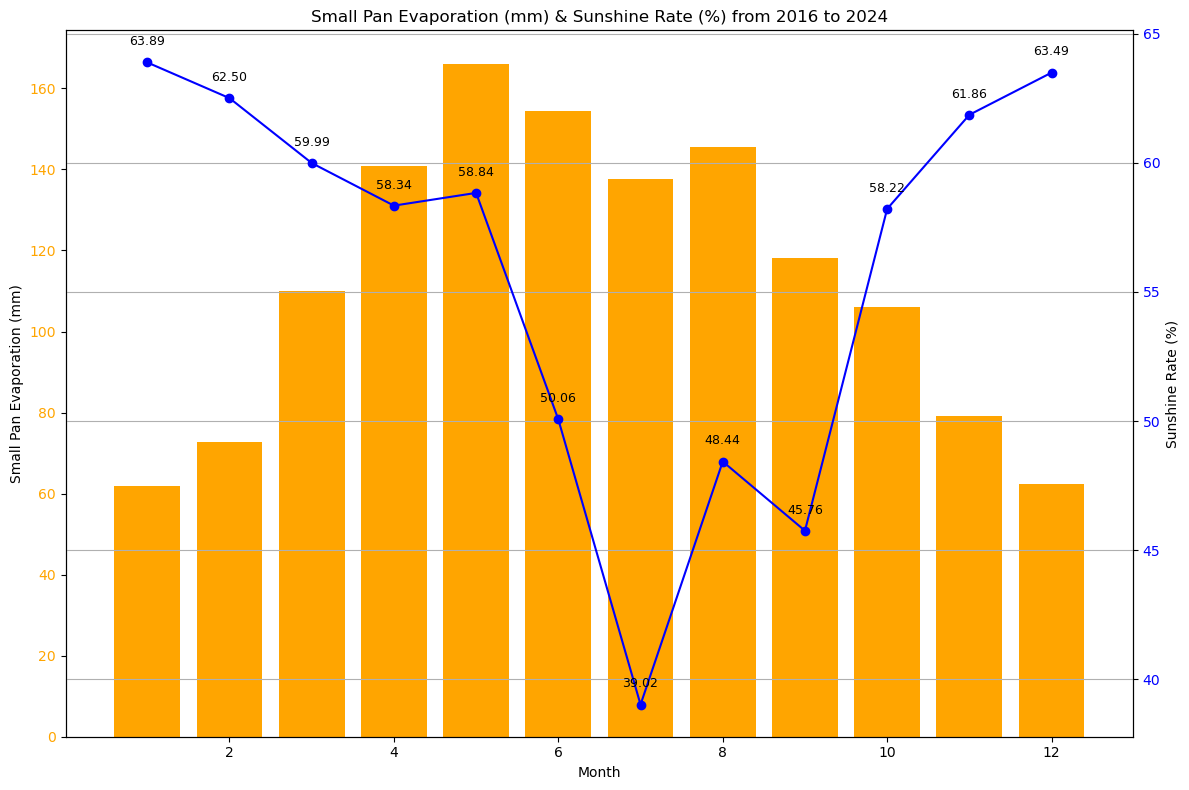

In [17]:
#Monthly sunlight and evaporation
dual_features_plot(a='Small Pan Evaporation (mm)', b='Sunshine Rate (%)', c='Month')

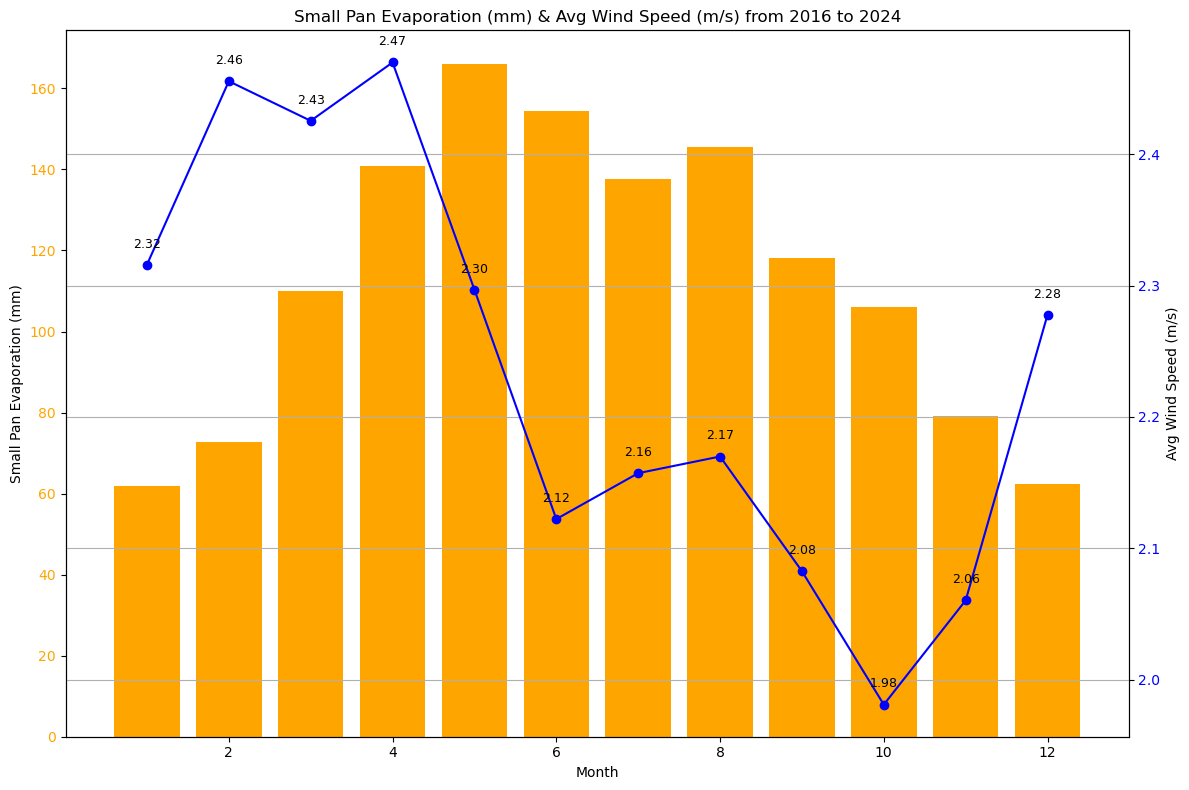

In [18]:
#Monthly avg wind speed and small pan evapouration
dual_features_plot(a='Small Pan Evaporation (mm)', b='Avg Wind Speed (m/s)', c='Month')

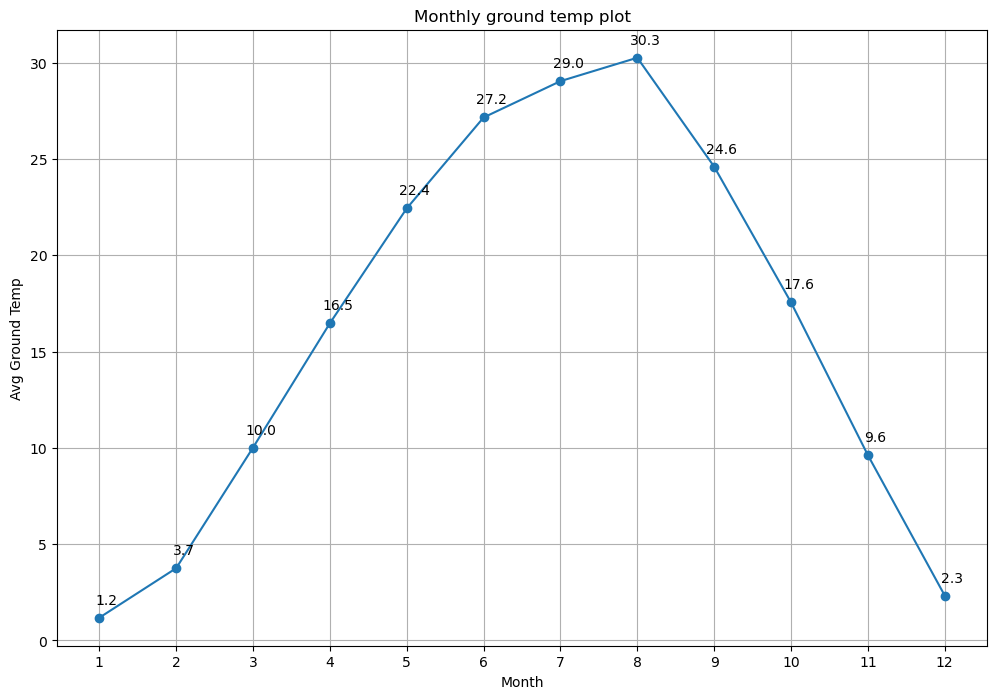

In [19]:
# Monthly ground temp plot
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()

plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

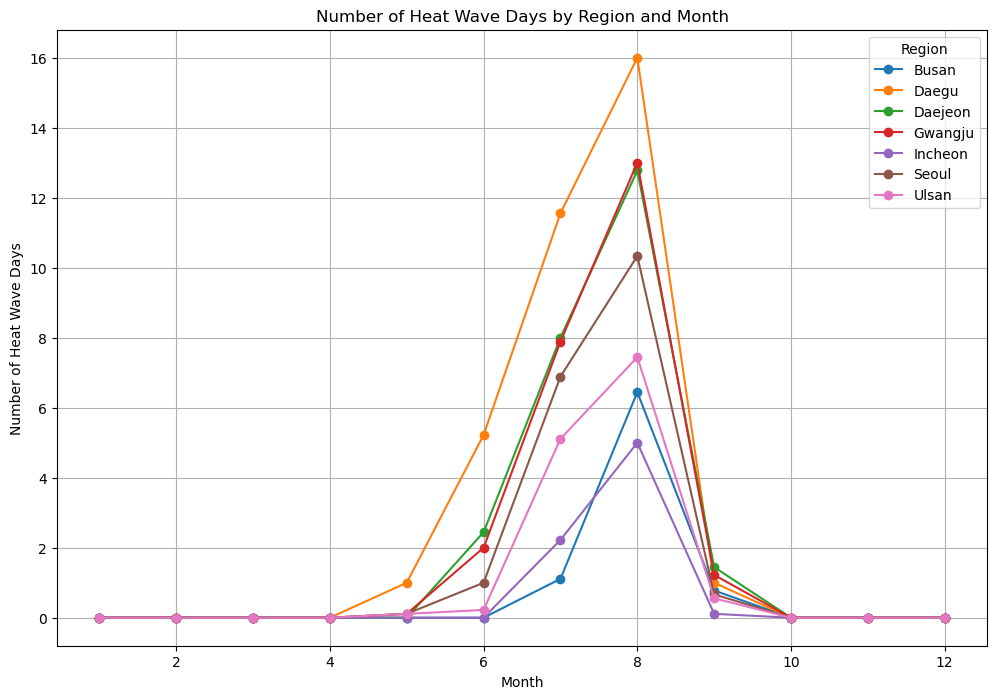

In [20]:
# Number of heat wave days per month by region
one_feature_two_group('Region','Month','Number of Heat Wave Days')

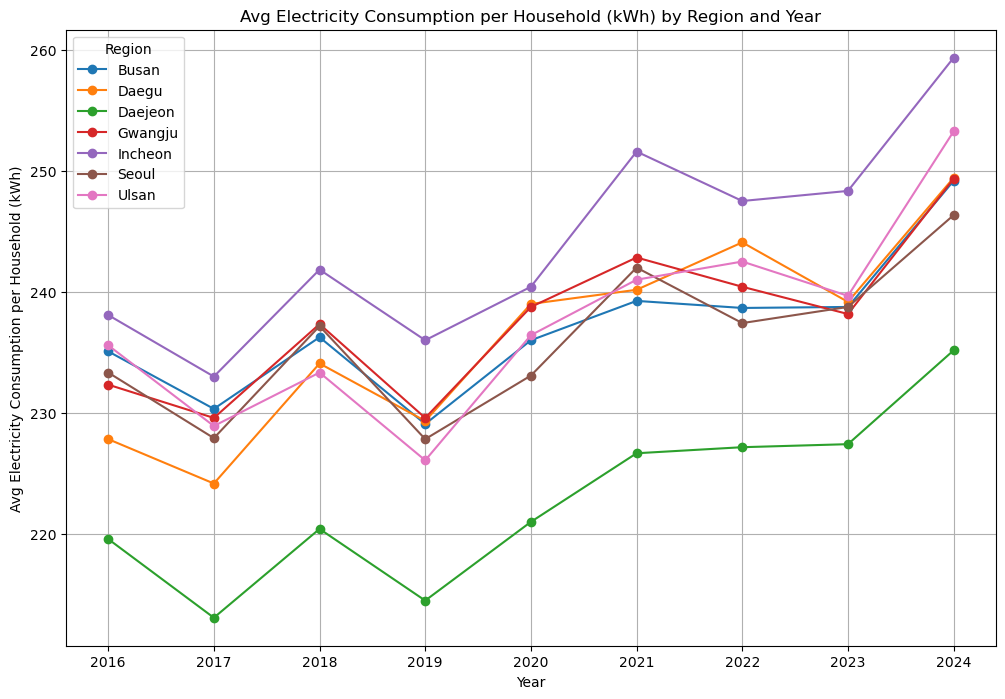

In [21]:
# Avg electricity consumption per household (kWh) by region
one_feature_two_group('Region','Year','Avg Electricity Consumption per Household (kWh)')

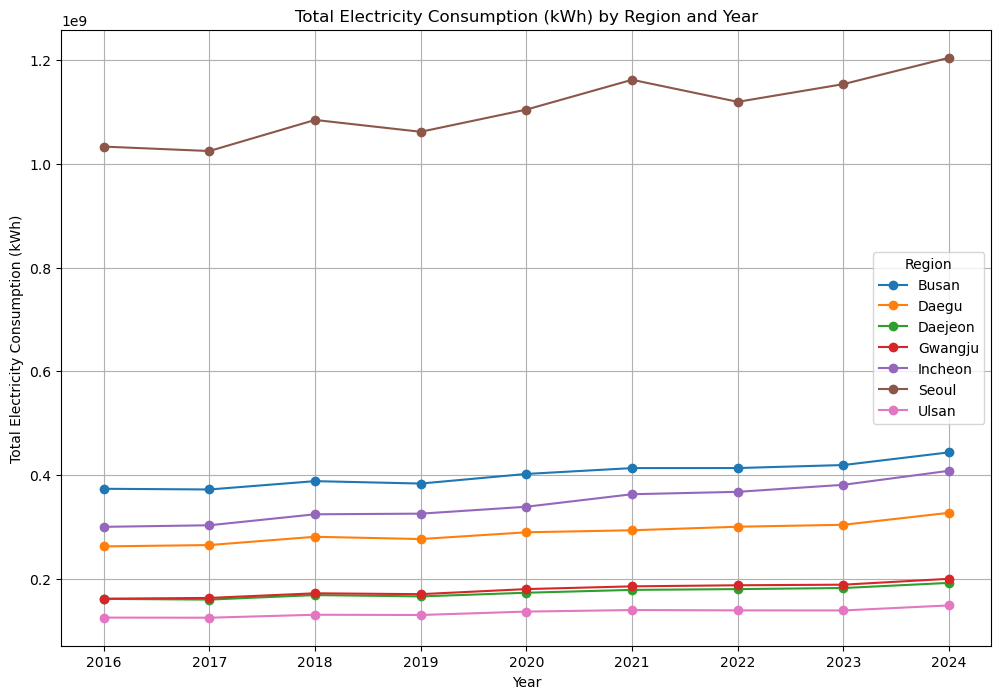

In [22]:
# Total electricity consumption (kWh) by region
df['Total Electricity Consumption (kWh)'] = df['Number of Households'] * df['Avg Electricity Consumption per Household (kWh)']
one_feature_two_group('Region','Year','Total Electricity Consumption (kWh)')
df = df.drop(columns=['Total Electricity Consumption (kWh)'])

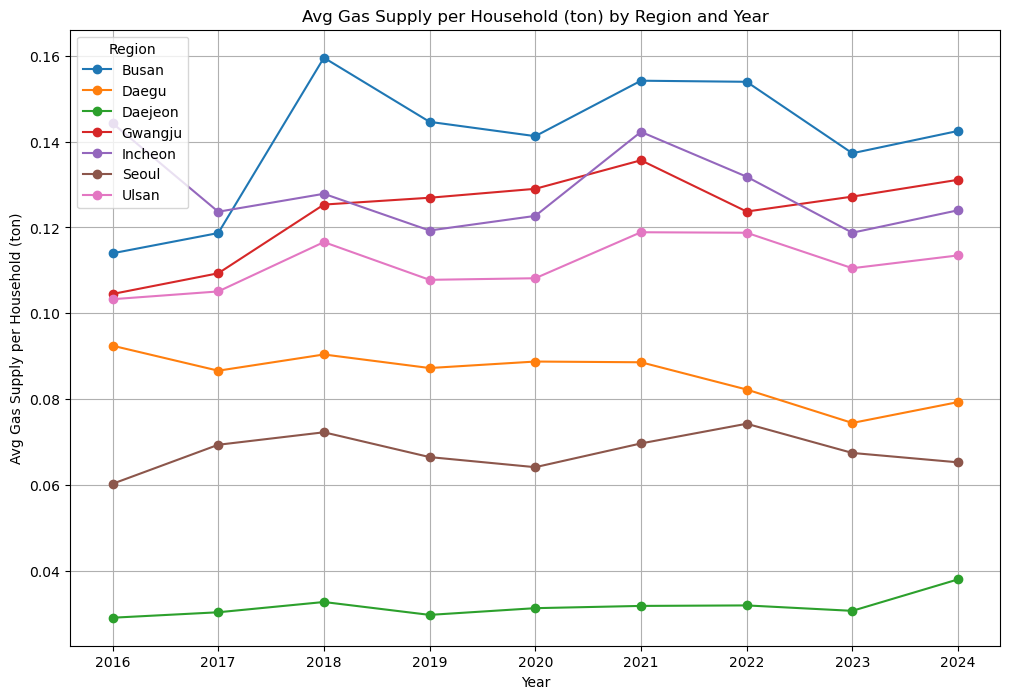

In [23]:
# Avg Gas Supply per Household (ton) by region
one_feature_two_group('Region','Year','Avg Gas Supply per Household (ton)')

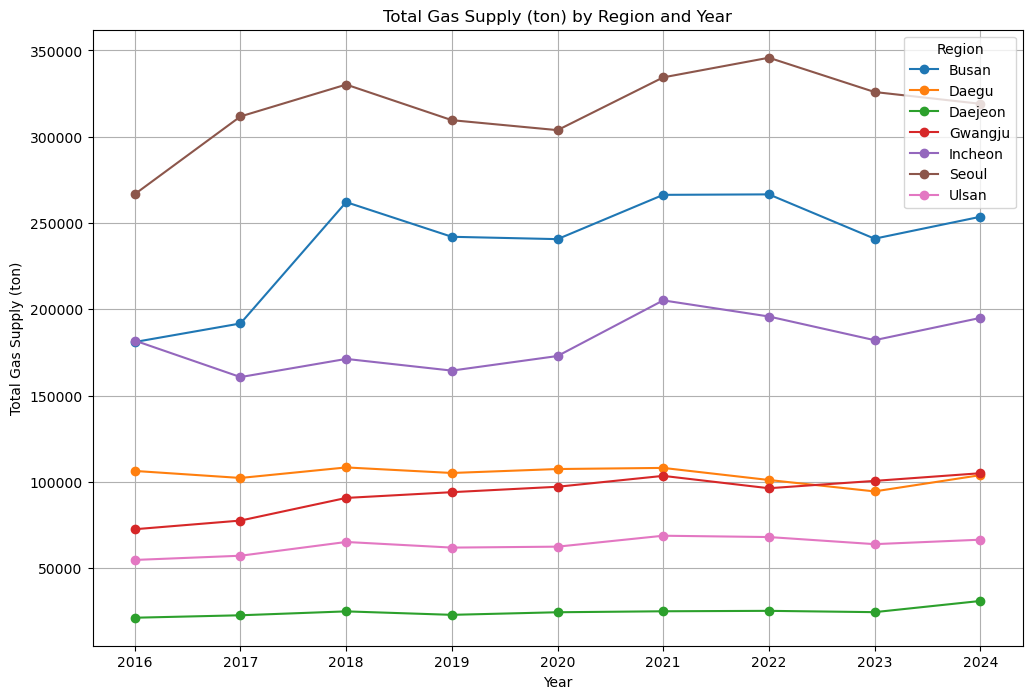

In [24]:
# Total gas supply (ton) by region
df['Total Gas Supply (ton)'] = df['Number of Households'] * df['Avg Gas Supply per Household (ton)']
one_feature_two_group('Region','Year','Total Gas Supply (ton)')
df = df.drop(columns=['Total Gas Supply (ton)'])

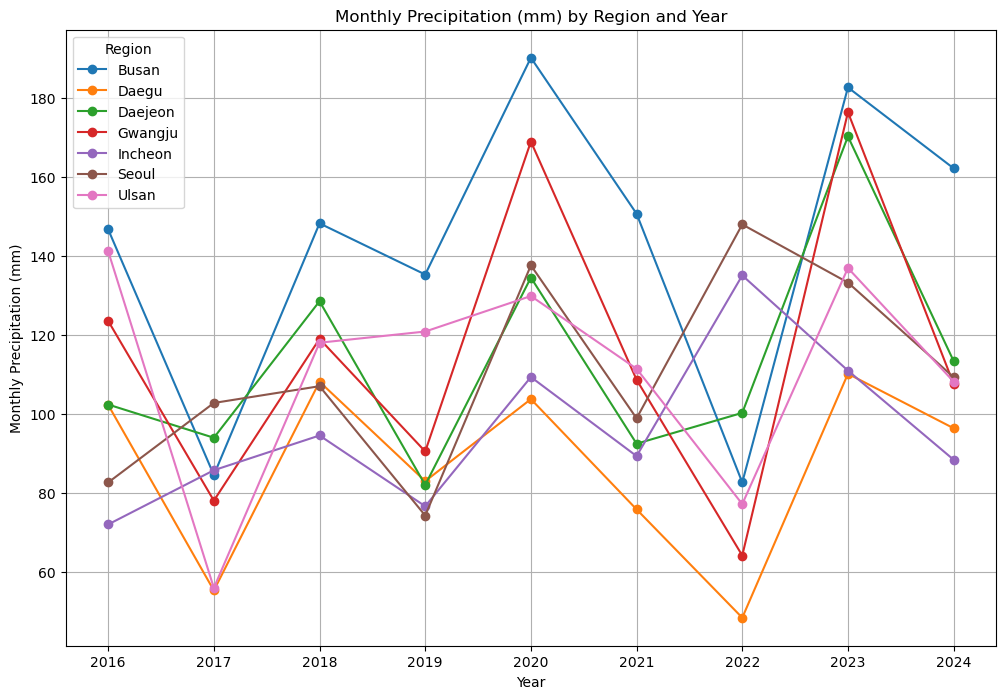

In [25]:
# Precipitation by region
one_feature_two_group('Region','Year','Monthly Precipitation (mm)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [26]:
def stepwise_selection(X, y,
					   initial_list=[],
					   threshold_in=0.05,
					   threshold_out=0.10,
					   verbose=True):
	"""
	Perform a stepwise feature selection based on p-values from statsmodels OLS.

	Parameters:
	- X : pd.DataFrame
		Candidate feature set (independent variables).
	- y : pd.Series or np.array
		Target variable (dependent variable).
	- initial_list : list
		Initial list of features to start the selection process.
	- threshold_in : float
		p-value threshold for adding a feature (smaller = more strict).
	- threshold_out : float
		p-value threshold for removing a feature (larger = more lenient).
	- verbose : bool
		Whether to print progress during feature selection.

	Returns:
	- included : list
		The final list of selected features.
	"""

	included = list(initial_list)  # Start with an initial list (could be empty)

	while True:
		changed = False  # Flag to track whether any feature was added or removed in the current iteration; If not, the loop will break

		# --- Forward Step ---
		# Try adding each feature not yet included and check p-values
		excluded = list(set(X.columns) - set(included))  # Compute the list of features not yet included in the model; These are the candidates for addition
		new_pval = pd.Series(index=excluded, dtype=float)  # Initialise a Series to store the p-values of each excluded feature if it were to be added to the model
		for new_column in excluded: # Iterate over all excluded features to assess their contribution
			# Fit OLS model with the current included features + this new one
			X_with_const = sm.add_constant(X[included + [new_column]]) # Prepare the design matrix with a constant term (intercept) and the current included features plus the candidate new feature
			model = sm.OLS(y, X_with_const).fit() # Fits an Ordinary Least Squares (OLS) linear regression model to the current design matrix
			new_pval[new_column] = model.pvalues[new_column]  # Extract the p-value of the newly added feature and stores it

		# Add the feature with the lowest p-value if it's below threshold_in
		if not new_pval.empty and new_pval.min() < threshold_in: # Check whether the smallest p-value among the excluded features is statistically significant, i.e., below the inclusion threshold
			best_pval = new_pval.idxmin()  # Feature with the smallest p-value
			included.append(best_pval)
			changed = True
			if verbose:
				print(f'Add {best_pval} with p-value {new_pval.min():.6f}')

		# --- Backward Step ---
		# Now check if any included feature should be removed
		X_with_const = sm.add_constant(X[included])
		model = sm.OLS(y, X_with_const).fit() # Re-fit the model using the current set of included features to re-calculate all p-values
		pvalues = model.pvalues.iloc[1:]  # Get p-values for all features excluding the intercept (which is the first value); These are the features being evaluated for possible removal

		# If any included feature has a p-value above threshold_out, remove the worst one
		if not pvalues.empty and pvalues.max() > threshold_out: # If the worst (largest) p-value among included features exceeds the exclusion threshold, it’s a candidate for removal
			worst_pval = pvalues.idxmax() # Find the feature with the worst (largest) p-value
			included.remove(worst_pval) # Remove this feature from the model
			changed = True
			if verbose:
				print(f'Drop {worst_pval} with p-value {pvalues.max():.6f}')

		# If no feature was added or removed, the process is done
		if not changed:
			break

	# Print final selected features and summary
	if verbose:
		print("\nFinal Selected Variables:")
		print(included)
		final_X_with_const = sm.add_constant(X[included])
		final_model = sm.OLS(y, final_X_with_const).fit()
		print("\nFinal Model Summary:")
		print(final_model.summary())

	return included

In [27]:
def weak_corr_col(X: pd.DataFrame, Y: pd.Series, feature: str, threshold: float):
	"""
	Identify numeric columns that are weakly correlated with a specified feature.

	Parameters:
	- X (pd.DataFrame): Feature dataset.
	- Y (pd.Series): Target variable to be appended for correlation analysis.
	- feature (str): The column name to compare correlations against.
	- threshold (float): Absolute correlation threshold; columns with correlation
						 less than this value will be returned.

	Returns:
	- pd.Index: Column names with absolute correlation to the specified feature
				less than the given threshold.
	"""
	df = pd.concat([X, Y], axis=1)
	df_numeric = df.select_dtypes(include=['number'])
	df_corr = df_numeric.corr()
	weak_corr_cols = df_corr[abs(df_corr[feature]) < threshold].index

	return weak_corr_cols

In [28]:
# Data split for features and target
X = df.drop(columns=['Avg Electricity Consumption per Household (kWh)', 'Avg Gas Supply per Household (ton)'])
y = df['Avg Electricity Consumption per Household (kWh)']
# y = df['Avg Gas Supply per Household (ton)']

In [29]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns

In [30]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# X4 - Stepwise selection (Run before the region one hot encoding)
stepwise_cols = stepwise_selection(X_train.select_dtypes(include=['number']), y_train, threshold_in=0.01, threshold_out=0.01, verbose=False)
X4_train = X_train[stepwise_cols]
X4_test = X_test[stepwise_cols]

# Scaling for X4
X4_scaler = StandardScaler()
X4_train.loc[:, stepwise_cols] = X4_scaler.fit_transform(X4_train[stepwise_cols])
X4_test.loc[:, stepwise_cols] = X4_scaler.transform(X4_test[stepwise_cols])

# Region one hot encoding
X4_train = pd.concat([X4_train, X_train['Region']], axis=1)
X4_test = pd.concat([X4_test, X_test['Region']], axis=1)
X4_train = pd.get_dummies(data=X4_train, columns=['Region'], dtype=int)
X4_test = pd.get_dummies(data=X4_test, columns=['Region'], dtype=int)

In [ ]:
# Region one hot encoding
X_train = pd.get_dummies(data=X_train, columns=['Region'], dtype=int)
X_test = pd.get_dummies(data=X_test, columns=['Region'], dtype=int)

# Scaling for X
X_scaler = StandardScaler()
X_train[numerical_cols] = X_scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = X_scaler.transform(X_test[numerical_cols])


In [33]:
# X0 - All
X0_train = X_train.copy()
X0_test = X_test.copy()


In [34]:
# X1 - Correlation
weak_corr_cols = weak_corr_col(X_train, y_train,'Avg Electricity Consumption per Household (kWh)', 0.2)
X1_train = X_train.drop(columns=(weak_corr_cols))
X1_test = X_test.drop(columns=(weak_corr_cols))


In [35]:
# X2 - PCA
pca = PCA()
pca.fit_transform(X_train)

# Find the features that contributes the most to PC 1
weights_pca = abs(pca.components_)
top_pc1_idx = np.argsort(weights_pca[0])[::-1][:15]
top_pc1_name = [X_train.columns[i] for i in top_pc1_idx]

# Grab features that contribute to PC 1
top_features = list(set(top_pc1_name))
pca_corr = X_train[top_features].corrwith(y_train)
pca_corr

# Drop columns w/ low contributions to PC 1
X2_train = X_train[top_features]
X2_test = X_test[top_features]


In [36]:
# X3 - VIF
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

vif_cols = df_vif[df_vif['VIF'] > 100]['feature']
X3_train = X_train.drop(columns=vif_cols)
X3_test = X_test.drop(columns=vif_cols)


### **Modelling**

In [37]:
def adj_r2_score(y_true: pd.Series, y_pred: pd.Series, X_features: pd.DataFrame) -> float:
	"""
	Compute the adjusted R² (coefficient of determination).

	Adjusted R² adjusts the regular R² score for the number of predictors (features)
	in the model. It penalizes the R² score for adding unnecessary predictors, helping
	to avoid overfitting.

	Parameters:
	- y_true : array-like of shape (n_samples,)
		True target values.
	- y_pred : array-like of shape (n_samples,)
		Predicted target values from the model.
	- X_features : array-like of shape (n_samples, n_features)
		Data used for getting the number of predictors (features) used in the model.

	Returns:
	- adj_r2 : float
		The adjusted R-squared score. Returns NaN if the number of predictors is too large
		for the formula to be valid (i.e., n <= p + 1).
	"""
	n = len(y_true)
	p = X_features.shape[1]

	# Prevent division by zero or negative denominator
	if n <= p + 1:
		warnings.warn("Adjust R^2 is undefined.")
		return float('nan')

	return 1 - (1 - r2_score(y_true, y_pred)) * (n - 1) / (n - p - 1)

In [38]:
def evaluate_model(model: BaseEstimator,
				   X_test: pd.DataFrame,
				   y_test: pd.Series) -> Tuple[pd.Series, float, float, float, float]:
	"""
	Train a regression model and evaluates its performance on the test set.

	Parameters:
		model (BaseEstimator): The regression model to train (already instantiated, e.g., from GridSearchCV.best_estimator_).
		X_test (pd.DataFrame): Testing features.
		y_test (pd.Series): Testing target values.

	Returns:
		Tuple containing:
			- y_pred (pd.Series): Predicted target values on the test set.
			- mae (float): Mean Absolute Error.
			- rmse (float): Root Mean Squared Error.
			- r2 (float): R-squared score.
			- adj_r2 (float): Adjusted R-squared score.
	"""

	model.fit(X_train, y_train)
	y_pred = model.predict(X_test)
	mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
	mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
	rmse = math.sqrt(mse)
	r2 = r2_score(y_true=y_test, y_pred=y_pred)
	adj_r2 = adj_r2_score(y_true=y_test, y_pred=y_pred, X_features=X_test)

	return y_pred, mae, rmse, r2, adj_r2

In [39]:
def generate_combinations(models_dict: Dict[str, Any], max_k:int, min_k: int) -> List[Tuple[Tuple[str, Any], ...]]:
	"""
    Generate all possible combinations of base learners from a dictionary of models,
    with combination sizes ranging from min_k to max_k.

    Parameters:
    models_dict : dict
        A dictionary where keys are model names and values are trained model objects.
        Example: {'ElasticNet': model_1, 'XGBRegressor': model_2}

    min_k : int, optional (default=2)
        The minimum number of base models in a combination.

    max_k : int, optional (default=6)
        The maximum number of base models in a combination.

    Returns:
    all_combos : list of tuples
        Each tuple contains a combination of (model_name, model_object) pairs.
        Example: [(('ElasticNet', model1), ('XGBRegressor', model2)), ...]
    """
	# Convert the dictionary into a list of (key, value) tuples
	items = list(models_dict.items())

	# Initialisation
	combinations = []

	# Ensure max_k does not exceed the number of available models
	max_k = min(max_k, len(items))

	# Generate combinations of size k from min_k to max_k
	for k in range(min_k, max_k + 1):
		combos = itertools.combinations(items, k)
		for combo in combos:
			combinations.append(combo)

	return combinations

In [ ]:
def plot_model_prediction (model: pd.DataFrame, feature_list: List):
	"""
	Visualise predicted vs actual values for different feature sets using scatter plots.

    Parameters
    ----------
    model : pd.DataFrame
        A pandas DataFrame containing prediction results.
        Required columns in the DataFrame:
            - 'Data': str or int, identifier for each feature set (should match elements in global variable X)
            - 'Model': str, name of the model
            - 'y_test': array-like, actual target values
            - 'y_pred': array-like, predicted target values
	feature_list : list
		List of features (X0, X1, etc.)
	"""

	num_plots = len(feature_list)
	num_cols = 3
	num_rows = math.ceil(num_plots / num_cols)
	fig, axes = plt.subplots(num_rows, num_cols, figsize=(13,13))
	axes =  axes.flatten()

	for i, feature in enumerate(feature_list):
		df = model[model['Data']==feature]
		ax = axes[i]
		label = df.iloc[0]['Model']
		x_data = np.array(df.iloc[0]['y_test'])
		y_data = np.array(df.iloc[0]['y_pred'])
		ax.scatter(x=x_data, y=y_data, label=label)

		min_val = min(ax.get_xlim()[0], ax.get_ylim()[0], x_data.min(), y_data.min())
		max_val = max(ax.get_xlim()[1], ax.get_ylim()[1], x_data.max(), y_data.max())
		padding = (max_val - min_val) * 0.05
		min_val -= padding
		max_val += padding

		line_points = np.array([min_val, max_val])
		ax.plot(line_points, line_points, color='red', linestyle='--', linewidth=1, label='y=x')
		ax.set_xlim(min_val, max_val)
		ax.set_ylim(min_val, max_val)
		ax.set_aspect('equal', adjustable='box')

		ax.set_ylabel('Predicted y')
		ax.set_xlabel('Actual y')
		ax.set_title(f'{feature} Feature')
		ax.grid(True)
		ax.legend()

	for j in range(i + 1, len(axes)):
		axes[j].set_visible(False)

	fig.suptitle(model.iloc[0]['Model'], fontsize=30, fontweight='bold', y=0.9)
	plt.tight_layout(w_pad=0,h_pad=-10)
	plt.show()

In [41]:
# Config setting
# Linear regression
model_linear_regression = LinearRegression()
hyperparams_linear_regression = {'fit_intercept': [True]}
config_linear_regression = [model_linear_regression, hyperparams_linear_regression]

# Elastic net
model_en = ElasticNet(random_state=42)
hyperparams_en = {'alpha': [0.1, 1, 10],
				  'l1_ratio': [0.1, 0.5, 0.9]}
config_en = [model_en, hyperparams_en]

# SVR
model_svr = SVR()
hyperparams_svr = {'kernel': ['poly', 'rbf', 'sigmoid'],
				   'C':[10, 100, 1000],
				   'epsilon':[0.3,0.5,0.8]}
config_svr = [model_svr, hyperparams_svr]

# Decision tree
model_dt = DecisionTreeRegressor(random_state=42)
hyperparams_dt = {'criterion': ['absolute_error', 'squared_error'],
				  'max_depth': [3, 5, 7, 10, None],
				  'min_samples_split': [2, 5, 10],
				  'min_samples_leaf': [1, 2, 4],
				  'max_features': ['sqrt', 'log2', None]}
config_dt = [model_dt, hyperparams_dt]

# Random forest
model_rf = RandomForestRegressor(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				  'max_depth': [None, 10, 20],
				  'min_samples_split': [2, 5, 10],
				  'min_samples_leaf': [1, 2, 4],
				  'bootstrap': [True, False],}
config_rf = [model_rf, hyperparams_rf]

# AdaBoost
model_ada = AdaBoostRegressor(random_state=42)
hyperparams_ada = {'n_estimators': [30, 50, 100],
				   'learning_rate': [0.01, 0.005, 0.001],}
config_ada = [model_ada, hyperparams_ada]

# XGB
model_xgb = XGBRegressor(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				   'learning_rate': [0.01, 0.05, 0.1],
				   'max_depth': [3, 5, 7]}
config_xgb = [model_xgb, hyperparams_xgb]

In [ ]:
# Statistics
models = [config_linear_regression, config_en, config_svr, config_dt, config_rf, config_ada, config_xgb]
X_trains = [X0_train, X1_train, X2_train, X3_train, X4_train]
X_tests = [X0_test, X1_test, X2_test, X3_test, X4_test]

# models = [config_linear_regression, config_en, config_svr]
# X_trains = [X0_train, X1_train]
# X_tests = [X0_test, X1_test]

# Initialisation
best_estimators_dict = {}
best_params_dict = {}
regression_results = []
stacking_results = []
feature_importances = []

# Iterate over each feature (X0, X1, ...)
for data_idx, (X_train, X_test) in enumerate(zip(X_trains, X_tests)):
	data_tag = f'X{data_idx}' # Label for current dataset
	#print(f"Running on {data_tag}")

	best_estimators_dict[data_tag] = {}
	best_params_dict[data_tag] = {}

	# Iterate over all models
	for model_idx, (estimator, param_grid) in enumerate(models):
		model_name = estimator.__class__.__name__

		# Training
		grid_search = GridSearchCV(estimator=estimator,
				    			   param_grid=param_grid,
								   cv=5)
		start_time = time.time()
		grid_search.fit(X_train, y_train)
		end_time = time.time()
		training_time = end_time - start_time

		# Store the best model and its hyperparameters
		best_model = grid_search.best_estimator_
		best_params = grid_search.best_params_
		best_estimators_dict[data_tag][model_name] = best_model
		best_params_dict[data_tag][model_name] = best_params

		# Testing and evaluating
		y_pred, mae, rmse, r2, adj_r2 = evaluate_model(best_model, X_test, y_test)

		# Log result
		regression_results.append({'y_test': list(y_test),
								   'y_pred': list(y_pred),
								   'Data': data_tag,
								   'Model': model_name,
								   'Training time': training_time,
								   'Best hyperparams': best_params,
								   'MAE': mae,
								   'RMSE': rmse,
								   'R^2': r2,
								   'Adjusted R^2': adj_r2})

	# Stacking
	estimators = best_estimators_dict[data_tag]

	# Rank models by adjusted R^2
	df_results = (pd.DataFrame([result for result in regression_results if result['Data']==data_tag])
				  .sort_values(by='Adjusted R^2', ascending=False)
				  .reset_index(drop=True))

	# Select the meta learner w/ top performances
	meta_learner_name = df_results.iloc[0]['Model']
	meta_model = estimators[meta_learner_name]

	# Select next best models as base learners
	base_candidates = df_results.iloc[1:]['Model'].tolist()
	base_objects = {name: estimators[name] for name in base_candidates}

	best_adj_r2 = 0
	best_combo = None
	best_stacking_model = None

	# print(f"[{data_tag}] Meta Learner: {meta_learner_name}")
	# print(f"[{data_tag}] Base candidates: {list(base_objects.keys())}")

	# Try all combinations of base learners
	for combo in generate_combinations(base_objects, max_k=6, min_k=1):
		# print(f"[{data_tag}] Trying combo: {combo}")
		combo_names, estimators_combo = zip(*combo)

		# Build the stacking model
		stack_model = StackingRegressor(estimators=list(zip(combo_names, estimators_combo)),
										final_estimator=meta_model,
										cv=5,
										n_jobs=-1)

		try:
			# Training and testing
			stack_model.fit(X_train, y_train)
			y_pred, mae, rmse, r2, adj_r2 = evaluate_model(stack_model, X_test, y_test)

			# Update adjusted R^2 score
			if adj_r2 > best_adj_r2:
				best_adj_r2 = adj_r2
				best_combo = combo_names
				best_stacking_model = stack_model
				# print(f">>> New best adjusted R^2: {best_adj_r2}")
		except Exception as e:
			print(f"Error during stacking with combination {combo_names}: {e}")

	# Log the best stacking model if one was found
	if best_stacking_model:
		y_pred, mae, rmse, r2, adj_r2 = evaluate_model(best_stacking_model, X_test, y_test)

		stacking_results.append({'y_test': list(y_test),
						   		 'y_pred': list(y_pred),
								 'Data': data_tag,
								 'Model': 'Stacking',
								 'Training time': 'N/A',
								 'Best hyperparams': {'Meta': meta_learner_name, 'Base': list(best_combo)},
								 'MAE': mae,
								 'RMSE': rmse,
								 'R^2': r2,
								 'Adjusted R^2': adj_r2})

		if isinstance(X_test, pd.DataFrame):
			feature_names = X_test.columns
		else:
			feature_names = [f'Feature {i}' for i in range(X_test.shape[1])]
			X_train = pd.DataFrame(X_train, columns=feature_names)
			X_test = pd.DataFrame(X_test, columns=feature_names)

		# Compute permutation importance
		result = permutation_importance(best_stacking_model,
										X_test,
										y_test,
										n_repeats=10,
										random_state=42,
										n_jobs=-1,
										scoring='r2')

		feature_names = X_test.columns if isinstance(X_test, pd.DataFrame) else [f'Feature {i}' for i in range(X_test.shape[1])]

		df_perm = (pd.DataFrame({'Data': data_tag,
								 'Feature': feature_names,
								 'Mean importance': result.importances_mean,
								 'Std importance': result.importances_std})
				   .sort_values(by='Mean importance', ascending=False)
				   .reset_index(drop=True))

		feature_importances.append(df_perm)

		# Compute drop-column importance
		# baseline_score = r2_score(y_true=y_test, y_pred=y_pred)

		# importances = []
		# for col in feature_names:
		# 	# Drop the feature
		# 	X_train_drop = X_train.drop(columns=[col])
		# 	X_test_drop = X_test.drop(columns=[col])

		# 	# Re-train the model on reduced feature set
		# 	stack_model_temp = clone(best_stacking_model)
		# 	try:
		# 		stack_model_temp.fit(X_train_drop, y_train)
		# 		drop_score = r2_score(y_true=y_test, y_pred=stack_model_temp.predict(X_test_drop))
		# 		importance = baseline_score - drop_score
		# 	except Exception as e:
		# 		print(f"Error computing drop-column importance for {col}: {e}")

		# 	importances.append(importance)

		# df_dropcol = (pd.DataFrame({'Data': data_tag,
		# 							'Feature': feature_names,
		# 							'Drop-column importance': importances})
		# 			  .sort_values(by='Drop-column importance', ascending=False)
		# 			  .reset_index(drop=True))

		# feature_importances.append(df_dropcol)

		# Compute SHAP
		# X_sample = shap.utils.sample(X=X_train, nsamples=100, random_state=42) # Sample on a subset of data

		# try:
		# 	# Use KernelExplainer for model-agnostic SHAP
		# 	explainer = shap.Explainer(best_stacking_model.predict, X_sample)
		# 	shap_values = explainer.shap_values(X_sample, nsamples='auto')

		# 	# Compute mean absolute SHAP value per feature
		# 	mean_abs_shap = np.abs(shap_values).mean(axis=0)

		# except Exception as e:
		# 	print(f"SHAP importance error for {data_tag}: {e}")

		# df_shap = (pd.DataFrame({'Data': data_tag,
		# 						 'Feature': feature_names,
		# 						 'SHAP importance': mean_abs_shap})
		# 		   .sort_values(by='SHAP importance', ascending=False)
		# 		   .reset_index(drop=True))

		# feature_importances.append(df_shap)

# Final DataFrame
df_regression = pd.DataFrame(regression_results)
df_stacking = pd.DataFrame(stacking_results)
df_models = pd.concat([df_regression, df_stacking])
df_feature_importance = pd.concat(feature_importances, ignore_index=True)

In [50]:
# Total Result
result_models = df_models.sort_values(by=['Model','Data'], ascending=[True, True])
result_models

In [51]:
# Model list
model_linear_regression = result_models[result_models['Model']=='LinearRegression']
model_en = result_models[result_models['Model']=='ElasticNet']
model_svr = result_models[result_models['Model']=='SVR']
model_dt = result_models[result_models['Model']=='DecisionTreeRegressor']
model_rf = result_models[result_models['Model']=='RandomForestRegressor']
model_ada = result_models[result_models['Model']=='AdaBoostRegressor']
model_xgb = result_models[result_models['Model']=='XGBRegressor']
model_stacking = result_models[result_models['Model']=='Stacking']
model_list = [model_linear_regression, model_en, model_svr, model_dt, model_rf, model_ada, model_xgb, model_stacking]

In [52]:
feature_list = ['X0', 'X1', 'X2', 'X3', 'X4']
for model in model_list:
	plot_model_prediction(model, feature_list=feature_list)

### **Neural Network**

In [ ]:
# Scaling for y
y_scaler = StandardScaler()
y_train_2d = y_train.values.reshape(-1, 1) # Change y into 2-D before scaling
y_test_2d = y_test.values.reshape(-1, 1)
y_train_scaled = y_scaler.fit_transform(y_train_2d)
y_test_scaled = y_scaler.transform(y_test_2d)
y_train_scaled = y_train_scaled.flatten() # Change y back to 1-D
y_test_scaled = y_test_scaled.flatten()

In [59]:
# Seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# NN hyperparameters
hyperparams_nn = {'units': [64, 128, 256],
				  'activation': ['relu', 'tanh'],
				  'l2': [0.001, 0.0001],
				  'optimizer': ['adam'],
				  'epochs': [100, 150],
				  'batch_size': [16, 32]}

# NN model
def nn_model(input_dim, units, activation, l2, optimizer):
	model = keras.Sequential([keras.Input(shape=(input_dim,)),
							  keras.layers.Dense(units, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
							  keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
							  keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
							  keras.layers.Dense(1)])
	model.compile(optimizer=optimizer, loss='mse')
	return model

best_score = -np.inf
best_params = None
best_model = None
nn_results = []

# Iterate through different hyperparameters to find best hyperparameters
for params in ParameterGrid(hyperparams_nn):
	#print(f"Trying params: {params}")
	model = nn_model(input_dim=X4_train.shape[1],
					 units=params['units'],
					 activation=params['activation'],
					 l2=params['l2'],
					 optimizer=params['optimizer'])
	# Training
	history = model.fit(X4_train, y_train_scaled,
						epochs=params['epochs'],
						batch_size=params['batch_size'],
						verbose=0, validation_split=0.2)
	
	# Testing
	y_pred = model.predict(X4_test)
	y_pred = y_scaler.inverse_transform(y_pred).flatten() #Inverse scaling

	# Evaluation
	adj_r2 = adj_r2_score(y_true=y_test, y_pred=y_pred, X_features=X4_test)
	
	# Update based on adjusted R^2
	if adj_r2 > best_score: 
		best_score = adj_r2
		best_params = params
		best_model = model
		r2 = r2_score(y_true=y_test, y_pred=y_pred)
		mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
		mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
		rmse = math.sqrt(mse)
		
		#print(f"✅ New Best Adjusted R²: {best_score:.4f} with {best_params}")

# Result		
# print(f"\n🎯 Best Hyperparameters Found: {best_params}")
nn_results.append({'y_test': list(y_test),
				   'y_pred': list(y_pred),
				   'Data': 'X4',
				   'Model': 'NN',
				   'Training time': 'N/A',
				   'Best hyperparams': best_params,
				   'MAE': mae,
				   'RMSE': rmse,
				   'R^2': r2,
				   'Adjusted R^2': best_score})
df_nn = pd.DataFrame(nn_results)
df_models = pd.concat([df_models, df_nn])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━

In [60]:
# Saving result file
df_models.to_csv('data/result/model_results.csv', index=False)

### **Visualisation**


1. ~2023 Train 2024 Test
2. ~2022 Train 2023 Test
3. ~2021 Train 2022 Test
4. ~2020 Train 2021 Test

In [ ]:
result_model = pd.read_csv('data/cleaned/Result_Model.csv')
result_stack = pd.read_csv('data/cleaned/Result_Stack.csv')

In [ ]:
#New Data predict
#df split
df = pd.read_csv('data/cleaned/energy_consumption.csv')
df_new = df[df['Year']<=2024] #2023 2022 
test_condition= (df_new['Year'] == 2024) #2023 2022 
df_test=df_new[test_condition]
df_train=df_new[~test_condition]

In [ ]:
#Train data / Test Data
#Train
X=df_train.drop(columns=['Avg Electricity Consumption per Household (kWh)'])
y=df_train['Avg Electricity Consumption per Household (kWh)']
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=42)

#Test
X_test = df_test.drop(columns=['Avg Electricity Consumption per Household (kWh)'])
y_test = df_test['Avg Electricity Consumption per Household (kWh)']

In [ ]:
#Feature Selection->X4
X_test=X_test[selected_variables]
X_train=X_train[selected_variables]
X_val=X_val[selected_variables]

In [ ]:
#Scaler
scale=StandardScaler()
numeric=X_train.select_dtypes(include=['number']).columns
X_train[numeric]=scale.fit_transform(X_train[numeric])
X_val[numeric]=scale.transform(X_val[numeric])
X_test[numeric]=scale.transform(X_test[numeric])

In [ ]:
#one-hot-encoding
X_train=pd.get_dummies(data=X_train, columns=['Region'], dtype=int)
X_val=pd.get_dummies(data=X_val, columns=['Region'], dtype=int)
X_test=pd.get_dummies(data=X_test, columns=['Region'], dtype=int)

In [ ]:
#인스턴스 model(param)
instantiated_models_info = []
#시각화 이름
visual_df_name=[]
num=0
#첫번째 y_pred에 있는 모델만 출력
result_high_pred=result_model.iloc[0]['y_test'] #왜 같은값이 두개씩 출력되지?
instant_condition=((result_model['Data_number']=='X4')&(result_model['y_test']==result_high_pred))
model_get=result_model[instant_condition]
model_get

#반복을 통해서 추출
for index,row in model_get.iterrows():
    model_name_str=row['Model']
    params_list_of_lists = row['best_params']
    params_list_of_lists = eval(params_list_of_lists)

    #모델명 클래스 찾기
    model_class = None #초기화
    model_maping={
        'LinearRegression':LinearRegression,
        'ElasticNet':ElasticNet,
        'RandomForestRegressor':RandomForestRegressor,
        'AdaBoostRegressor':AdaBoostRegressor,
        'DecisionTreeRegressor':DecisionTreeRegressor,
        'SVR':SVR,
        'XGBRegressor':XGBRegressor
    }
    model_class = model_maping.get(model_name_str)

    #하이퍼파라미터 리스트->딕션너리
    hyperparams_dict = {} # 최종 딕셔너리 초기화
    hyperparams_dict = dict(params_list_of_lists)



    #모델 인스턴스 생성
    model = model_class(**hyperparams_dict)


    #모델 저장
    instantiated_models_info.append({'name':model_name_str,'instance':model})
    print(num)
    #모델 훈련
    start_time=time.time()
    model.fit(X_train,y_train)
    end_time=time.time()

    #val,test 예측
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    #val metric
    val_MAE=mean_absolute_error(y_val,y_pred_val)
    val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
    val_R2=r2_score(y_val,y_pred_val)
    val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

    #test metric
    test_MAE=mean_absolute_error(y_test,y_pred_test)
    test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
    test_R2=r2_score(y_test,y_pred_test)
    test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

    #val,test DF
    val_df=pd.DataFrame({'y_test':y_test,
                         'y_pred':y_pred_test,
                         'val_MAE':val_MAE,
                         'test_MAE':test_MAE,
                         'val_RMSE':val_RMSE,
                         'test_RMSE':test_RMSE,
                         'val_R2':val_R2,
                         'test_R2':test_R2,
                         'val_adj_R2':val_adj_r2,
                         'test_adj_R2':test_adj_r2})
    val_df['Model_n']= model_name_str



    #visual_df

    visual_df=pd.DataFrame({'y_test':y_test,
                         'y_pred':y_pred_test})
    visual_df['Model_n']= model_name_str
    name=model_name_str+'_pred'
    globals()[name]=pd.concat([df_test,visual_df],axis=1)
    visual_df_name.append(name)

    if num == 0:
        new_data_df=val_df
    else:
        new_data_df=pd.concat([new_data_df,val_df])
    num+=1
for i in range(len(visual_df_name)):
    if i==0:
        All_new_data=globals()[visual_df_name[i]]
    else:
        All_new_data=pd.concat([All_new_data,globals()[visual_df_name[i]]])


In [ ]:
# #스태킹
stack_condition=((result_stack['Data_number']=='X4')&(result_stack['y_test']==result_high_pred))
stack_get=result_stack[stack_condition]
stack_get=stack_get['best_params'].iloc[0]
stack_get = eval(stack_get)
meta_model_name = stack_get[0][1]
base_mdoel_name = stack_get[1]


#메타모델 인스턴스
for item_dict in instantiated_models_info:
    if item_dict.get('name') == meta_model_name:
        found_meta_instance=item_dict['instance']
        break

#베이스 모델 인스턴스
base_model=[]

for i in range(len(base_mdoel_name)):
    for item_dict in instantiated_models_info:
        if item_dict.get('name') == base_mdoel_name[i]:
            found_base=item_dict['instance']
            base_name=item_dict['name']
            base_model.append((base_name,found_base))
            break

base_model
# base_model
ladder = StackingRegressor(estimators=base_model,
                    final_estimator=found_meta_instance,
                    cv=5)

ladder.fit(X_train,y_train)

y_pred_val = ladder.predict(X_val)
y_pred_test = ladder.predict(X_test)

#val metric
val_MAE=mean_absolute_error(y_val,y_pred_val)
val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
val_R2=r2_score(y_val,y_pred_val)
val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

#test metric
test_MAE=mean_absolute_error(y_test,y_pred_test)
test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
test_R2=r2_score(y_test,y_pred_test)
test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

#val,test DF
val_df=pd.DataFrame({'y_test':y_test,
                    'y_pred':y_pred_test,
                    'val_MAE':val_MAE,
                    'test_MAE':test_MAE,
                    'val_RMSE':val_RMSE,
                    'test_RMSE':test_RMSE,
                    'val_R2':val_R2,
                    'test_R2':test_R2,
                    'val_adj_R2':val_adj_r2,
                    'test_adj_R2':test_adj_r2})
val_df['Model_n']= 'Stacking'
new_data_df=pd.concat([new_data_df,val_df])

#visual_df

visual_df=pd.DataFrame({'y_test':y_test,
                        'y_pred':y_pred_test})
visual_df['Model_n']= 'Stacking'
name='Stacking'+'_pred'
globals()[name]=pd.concat([df_test,visual_df],axis=1)
visual_df_name.append(name)

In [ ]:
#NN
best_params = {
    'units': 256,
    'activation': 'tanh',
    'l2': 0.0001,
    'optimizer': 'adam',
    'epochs': 100,
    'batch_size': 16
}

y_scale=StandardScaler()
y_train_2d = y_train.values.reshape(-1, 1)
y_train_scaled = y_scale.fit_transform(y_train_2d)


# 시드 고정
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# ✅ 베스트 모델 구성
def build_model(input_dim, units, activation, l2, optimizer):
    model = keras.Sequential([
        keras.layers.Dense(units, activation=activation, input_shape=(input_dim,), kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//2, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(units//4, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2)),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer, loss='mse')
    return model

# 모델 학습 및 평가
start_time = time.time()

  # 전처리된 베스트 데이터셋 사용
model = build_model(
    input_dim=X_train.shape[1],
    units=best_params['units'],
    activation=best_params['activation'],
    l2=best_params['l2'],
    optimizer=best_params['optimizer']
)

history = model.fit(X_train, y_train_scaled,
                    epochs=best_params['epochs'],
                    batch_size=best_params['batch_size'],
                    verbose=1)

end_time = time.time()

# 예측 및 역변환
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)
y_pred_val= y_scale.inverse_transform(y_pred_val).flatten()
y_pred_test = y_scale.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()


#val metric
val_MAE=mean_absolute_error(y_val,y_pred_val)
val_RMSE=np.sqrt(mean_squared_error(y_val,y_pred_val))
val_R2=r2_score(y_val,y_pred_val)
val_adj_r2=adj_r2_score(y_val,y_pred_val,X_val)

#test metric
test_MAE=mean_absolute_error(y_test,y_pred_test)
test_RMSE=np.sqrt(mean_squared_error(y_test,y_pred_test))
test_R2=r2_score(y_test,y_pred_test)
test_adj_r2=adj_r2_score(y_test,y_pred_test,X_test)

#val,test DF
val_df=pd.DataFrame({'y_test':y_test,
                    'y_pred':y_pred_test,
                    'val_MAE':val_MAE,
                    'test_MAE':test_MAE,
                    'val_RMSE':val_RMSE,
                    'test_RMSE':test_RMSE,
                    'val_R2':val_R2,
                    'test_R2':test_R2,
                    'val_adj_R2':val_adj_r2,
                    'test_adj_R2':test_adj_r2})
val_df['Model_n']= 'NN'
new_data_df=pd.concat([new_data_df,val_df])

#visual_df

visual_df=pd.DataFrame({'y_test':y_test,
                        'y_pred':y_pred_test})
visual_df['Model_n']= 'NN'
name='NN'+'_pred'
globals()[name]=pd.concat([df_test,visual_df],axis=1)
visual_df_name.append(name)

Epoch 1/100


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0165   
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5454 
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4969 
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4478 
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4102 
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3817 
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3566 
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3359 
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3194 
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3039 
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2864 
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2659 
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2440 
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2224 
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2023 

In [ ]:
#Full model set
for i in range(len(visual_df_name)):
    if i==0:
        All_new_data=globals()[visual_df_name[i]]
    else:
        All_new_data=pd.concat([All_new_data,globals()[visual_df_name[i]]])

In [ ]:
Actual_y = All_new_data.groupby(['Model_n', 'Month'])['y_test'].mean()
Predic_y = All_new_data.groupby(['Model_n', 'Month'])['y_pred'].mean()

unique_model = Actual_y.index.get_level_values('Model_n').unique()
n_model = len(unique_model)
n_cols = 3
n_rows = math.ceil(n_model / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), squeeze=False)
fig.suptitle('2024 Year Predict', fontsize=30, fontweight='bold')
axes_flat = axes.flatten()
last_plotted_idx = -1


for i, model_name in enumerate(unique_model):
    # 현재 모델이름에 위치하는 ax축 선택
    ax = axes_flat[i]
    last_plotted_idx = i
    actual_data = Actual_y.loc[model_name]
    predict_data = Predic_y.loc[model_name]

    # 현재 축(ax)에 실제값과 예측값 그래프 그리기
    ax.plot(actual_data, label='Actual',marker='o')
    ax.plot(predict_data, label='Predicted',  linestyle='--', marker='x')

    # 각 서브플롯 꾸미기
    ax.set_title(f'Model: {model_name}')      # 플롯 제목 설정
    ax.set_xlabel('Month')                    # x축 레이블
    ax.set_ylabel('Avg Consumption (kWh)')    # y축 레이블 (단위 확인 필요)
    ax.grid(True)                             # 그리드 표시
    ax.legend()                               # 범례 표시 확실히 하기

for j in range(last_plotted_idx+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# 전체 레이아웃 조정 및 플롯 보여주기
plt.tight_layout()
# tight_layout() 호출 후 suptitle 공간 확보

plt.show()


### **Time Series Analysis**

In [ ]:
# Load file
df = pd.read_csv('data/cleaned/energy_consumption.csv')
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

In [ ]:
# Select target
y = df['Avg Electricity Consumption per Household (kWh)']
y = y.resample('MS').mean()
title = 'Avg Electricity Consumption per Household (kWh)'

# y = df['Avg Gas Supply per Household (ton)']
# y = y.resample('MS').mean()
# title = 'Avg Gas Supply per Household (ton)'

In [ ]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -0.19247002349430503 | p-val: 0.9394132388507639


In [ ]:
# Split into train and test data
date = '2023-01-01'
y_train, y_test = y[:date], y[date:]

In [ ]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                              SARIMAX Results                                              
Dep. Variable:     Avg Electricity Consumption per Household (kWh)   No. Observations:                   85
Model:                              SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -290.824
Date:                                             Wed, 09 Apr 2025   AIC                            591.647
Time:                                                     19:11:00   BIC                            603.030
Sample:                                                 01-01-2016   HQIC                           596.179
                                                      - 01-01-2023                                         
Covariance Type:                                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [ ]:
# Prediction
y_pred = sarimax_fit.get_prediction(start=y_test.index[0], end=y_test.index[-1])

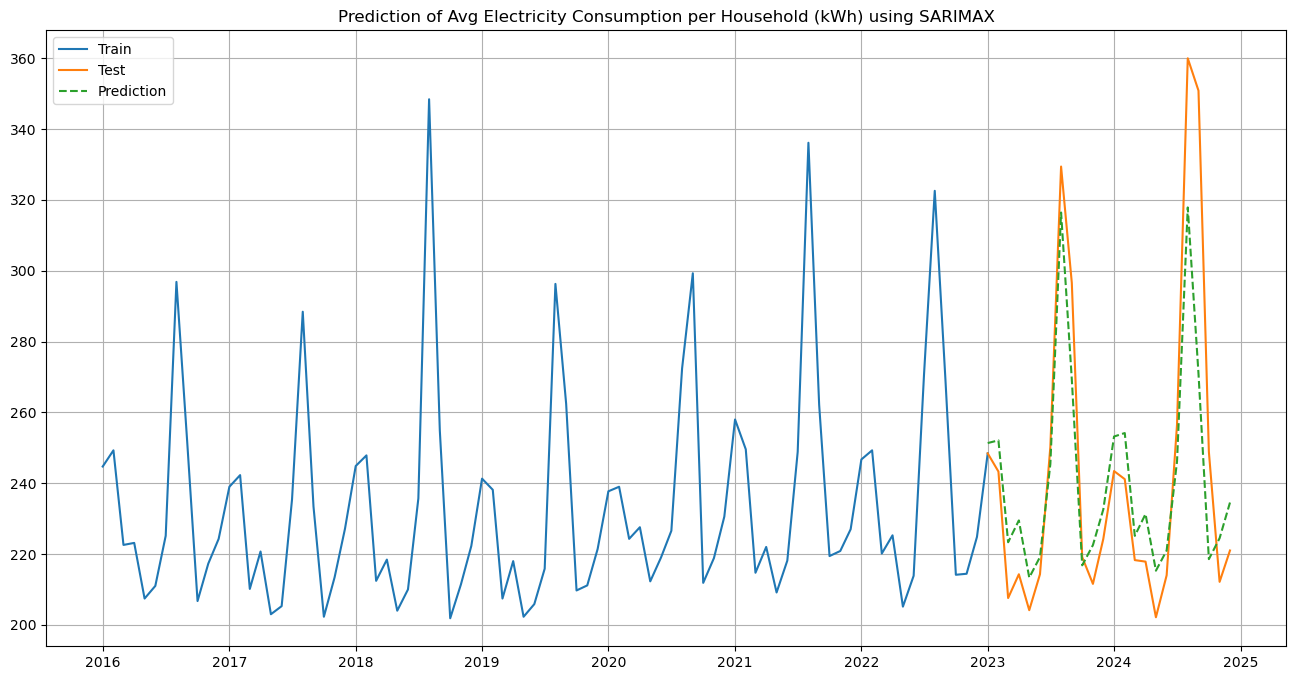

In [ ]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred.predited_mean, label='Prediction', linestyle='--')c
plt.legend()
plt.title(f"Prediction of {title} using SARIMAX")
plt.grid()
plt.show()